---
# pRF experiment

This notebook contains an initial analysis of the pRF-data (run-2 and run-5). Each run had 3 iterations of the pRF-design, meaning we will average runs, and iterations.

In [1]:
%reload_ext autoreload
%autoreload 1

In [2]:
from linescanning import utils,prf
import numpy as np
import warnings
import matplotlib.pyplot as plt
import os
import pandas as pd
opj = os.path.join

warnings.simplefilter('ignore')
project_dir = os.environ.get("DIR_PROJECTS")
base_dir = os.path.join(project_dir, 'hemifield')

plot_vox = 359

Fetch the files representing the functional data (`bold.mat` > `call_linerecon`), experiment log file `events.tsv` > `exptools2`), regressor file (`physio.txt`) and mat-file (`physio.mat`) physio files (`call_spmphysio`). `run_files` collects all these files in a list, from which we can then pick the required files and store them in their respective variable

In [77]:
# Load data
sub         = '003'
ses         = 3
task        = "task-pRF"
run         = [2,5]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")

df_func = []
df_onsets = []
df_physio = []
for ix,rr in enumerate(run):

    run_files   = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}", f"run-{rr}"], func_dir)
    func_file   = utils.get_file_from_substring("bold.mat", run_files)
    exp_file    = utils.get_file_from_substring("events.tsv", run_files)

    print(f"Loading {func_file}")
    bp_type = "rolling"
    window = None

    func = utils.ParseFuncFile(func_file, 
                               subject=1, 
                               run=ix+1, 
                               deleted_first_timepoints=0, 
                               deleted_last_timepoints=0,
                               bp_filter=bp_type,
                               window_size=window)
                            
    onset = utils.ParseExpToolsFile(exp_file,
                                    subject=func.subject,
                                    run=func.run,
                                    delete_vols=(func.deleted_first_timepoints),
                                    TR=func.TR)

    # Fetch dataframes
    onset_df    = onset.get_onset_df(index=False)
    filtered    = func.dct_psc_rol.reset_index()

    # append to list
    df_func.append(filtered)
    df_onsets.append(onset_df)

df_func     = pd.concat(df_func).set_index(['subject', 'run', 't'])
df_onsets   = pd.concat(df_onsets).set_index(['subject', 'run', 'event_type'])
avg_func    = df_func.groupby(['subject', 't']).mean()
print(avg_func.shape)

Loading /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-pRF_run-2_bold.mat
Loading /mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-pRF_run-5_bold.mat
(4800, 720)


Here we start to chunk up the average timecourse into the individual iterations:
- $baseline_{tr} = 30s / 0.105s \approx 285.71 $ trials. Because we're dealing with volumes and TRs, we need an integer, so let's say $286$
- Each iteration = $160$ seconds, so $160/0.25 \approx 1523.81$ trials. Again, make integer: $1524$ trials per iteration
- We have three iterations, but for some reason the number of trials exceeded the number of volumes (timing of the sequence seems difficult to predict with multi-echo acquisition..?)
- Now I loop through the number of iterations starting from $286$ with steps of $1524$.
- The final iteration doesn't have enough volumes for this operation, so it's zero-padded at the end
- The output of this is a numpy-array with shape `(1524, 720, 3)` for `(<volumes>, <n_voxels>, <iterations>)`, which is then concatenated over the last axis

Q: what to do about the baseline? There's no average for baseline, so if we add the baseline back after averaging we have a rather tumultuous beginning of the timecourse followed by smoother timecourse due to averaging

In [46]:
n_iter = 3
iter_chunks = []
start = 286
iter_size = 1524
baseline = avg_func[:start]
for ii in range(n_iter):

    
    # try to fetch values, if steps are out of bounds, zero-pad the timecourse
    if start+iter_size < avg_func.shape[0]:
        chunk = avg_func.values[start:start+iter_size]
    else:
        chunk = avg_func.values[start+iter_size:]
        padded_array = np.zeros((iter_size, 720))
        padded_array[:chunk.shape[0]] = chunk
        chunk = padded_array.copy()

    iter_chunks.append(chunk[...,np.newaxis])
    start += iter_size
    print(f"Chunk size = {chunk.shape}")

avg_iters_baseline = np.concatenate((baseline, np.concatenate(iter_chunks, axis=-1).mean(axis=-1)))
avg_iters_no_baseline = np.concatenate(iter_chunks, axis=-1).mean(axis=-1)
print(f"Final func data (w/o baseline) has shape: {avg_iters_no_baseline.shape}")

Chunk size = (1524, 720)
Chunk size = (1524, 720)
Chunk size = (1524, 720)
Final func data (w/o baseline) has shape: (1524, 720)


Here I plotted the average timecourse with the iterations marked in shaded bands

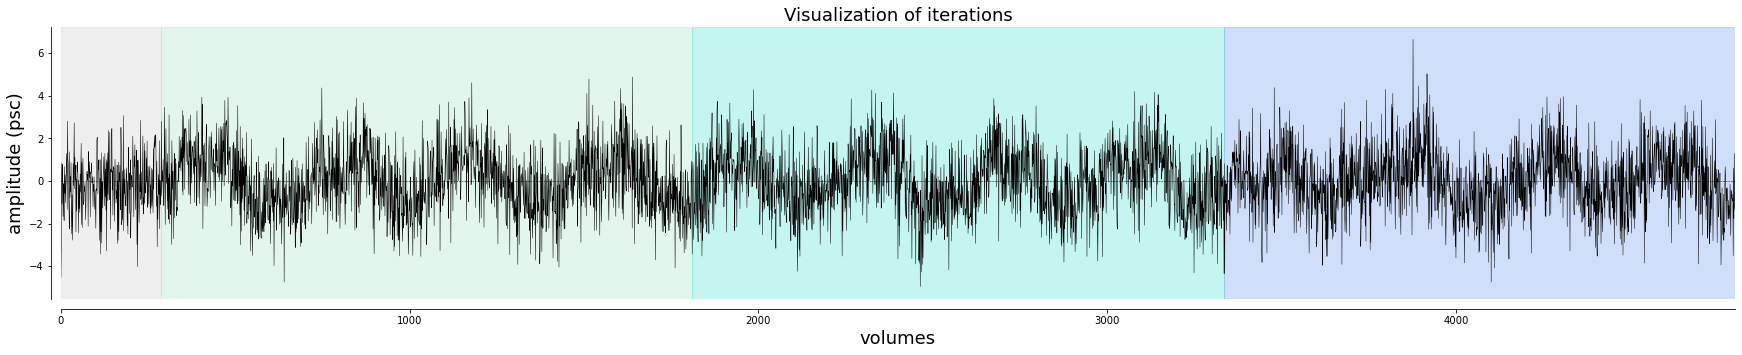

In [51]:
# use this setup so we can add the shaded boxes
fig,axs = plt.subplots(figsize=(30,5))
x = np.arange(0, len(avg_func[f'vox {plot_vox}'].values), step=1)

# shaded boxes for iterations
axs.axvspan(0, 286, alpha=0.3, color="#cccccc")
axs.axvspan(286, 286+iter_size, alpha=0.3, color="#9FE2BF")
axs.axvspan(286+iter_size, 286+(iter_size*2), alpha=0.3, color="#40E0D0")
axs.axvspan(286+(iter_size*2), avg_func.shape[0], alpha=0.3, color="#6495ED")

# timecourse
utils.LazyPlot(avg_func[f'vox {plot_vox}'].values,
               axs=axs,
               line_width=0.5,
               color="#000000",
               x_label="volumes",
               title="Visualization of iterations",
               y_label="amplitude (psc)",
               add_hline='default',
               sns_trim=False,
               x_lim=[0,avg_func[f'vox {plot_vox}'].values.shape[0]],
               font_size=18)

Below the averaged timecourses across the cortical ribbon at our target vertex without adding back the baseline

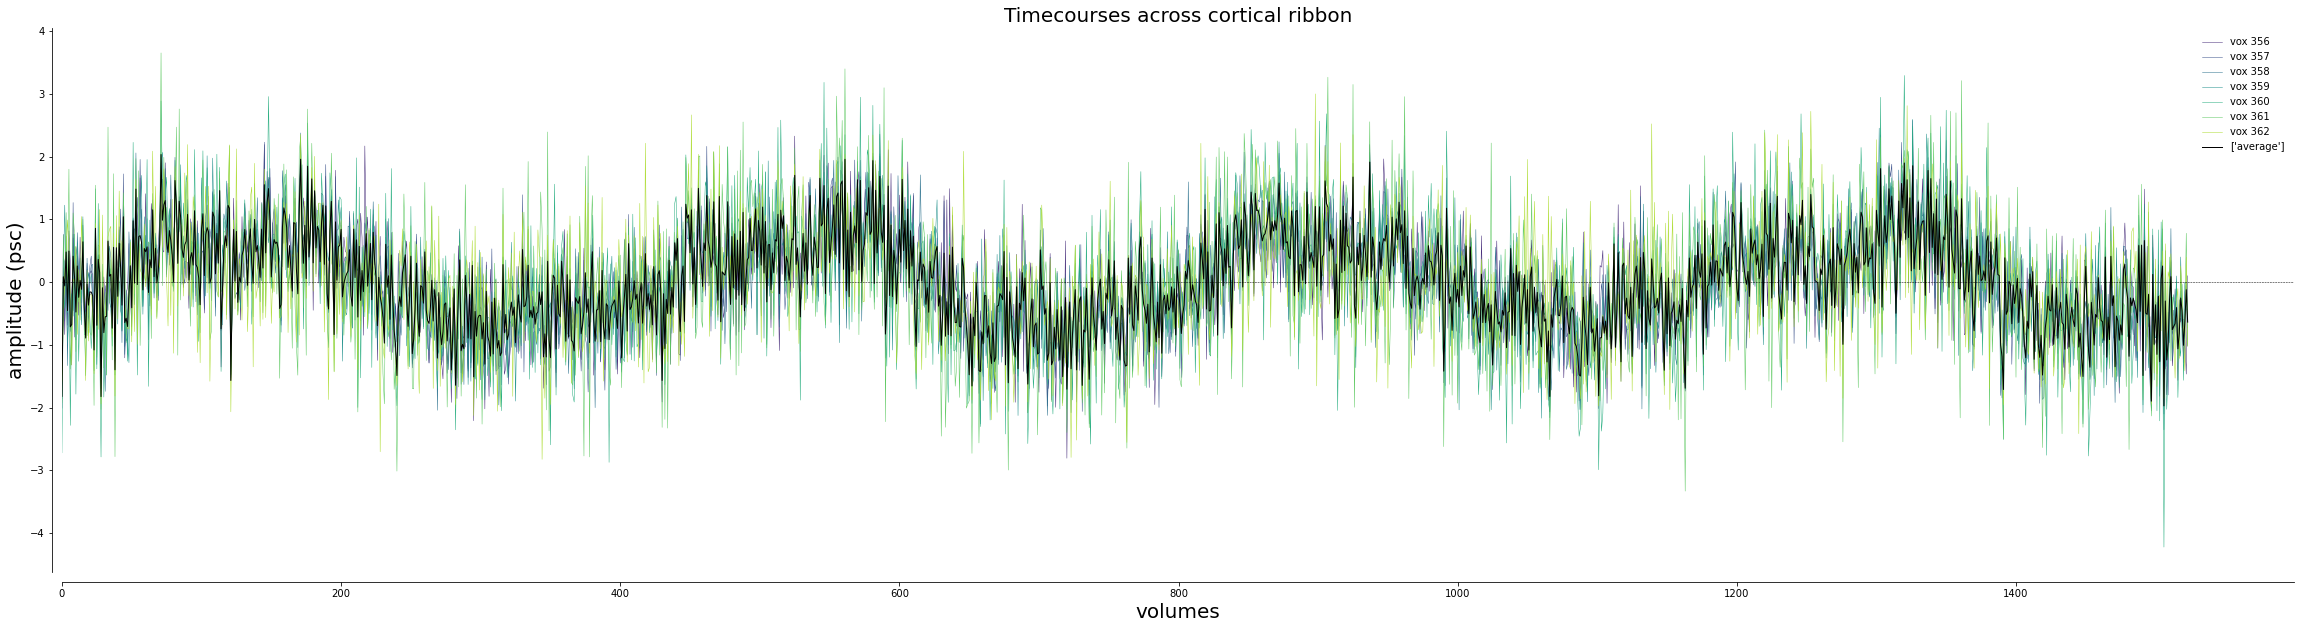

In [76]:
fig,axs = plt.subplots(figsize=(40,10))

ribbon      = [356,363]
include_vox = np.arange(*ribbon)
data = [avg_iters_no_baseline[:, ii] for ii in include_vox]

# get average across depth w/ different color
avg_ribbon = [ii[...,np.newaxis] for ii in data]
avg_ribbon = np.concatenate(avg_ribbon, axis=-1).mean(axis=-1)

labels = [f'vox {ii}' for ii in include_vox]

# plot individual voxels
utils.LazyPlot(data,
               axs=axs,
               x_label="volumes",
               y_label="amplitude (psc)",
               title="Timecourses across cortical ribbon",
               labels=labels,
               add_hline='default',
               set_xlim_zero=True,
               sns_trim=False,
               line_width=0.5,
               font_size=20)

# plot average
utils.LazyPlot(avg_ribbon,
               axs=axs,
               color="#000000",
               labels=['average'],
               set_xlim_zero=True,
               sns_trim=False,
               line_width=1,
               font_size=20)               

What to do about the baseline.. This is not average over iterations, only over the two pRF-runs.. So adding is back to the timecourse averaged over iterations looks a bit off..

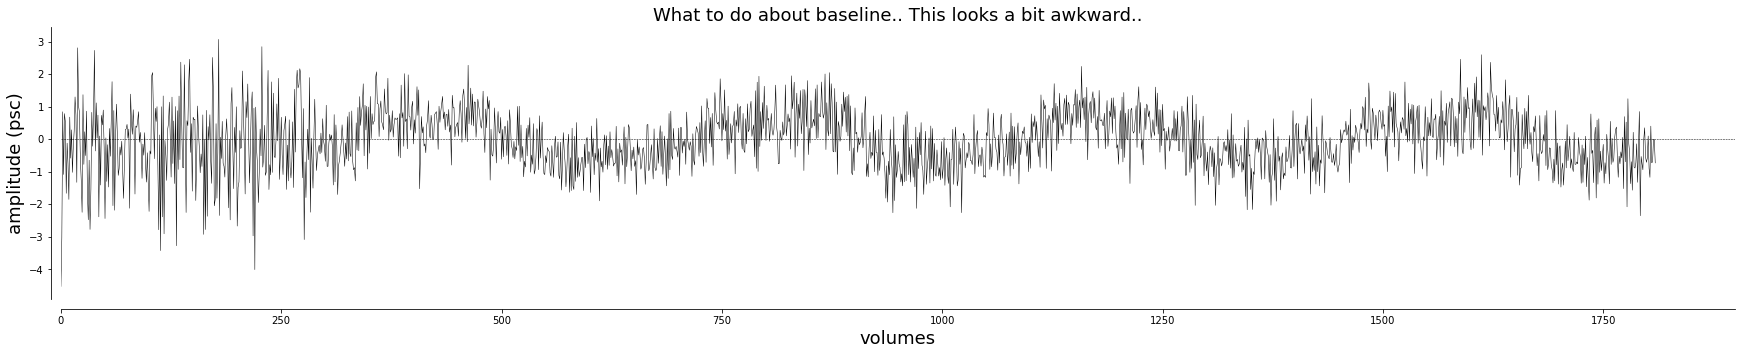

In [50]:
utils.LazyPlot(avg_iters_baseline[:, plot_vox],
               figsize=(30,5),
               line_width=0.5,
               color="#000000",
               x_label="volumes",
               y_label="amplitude (psc)",
               title="What to do about baseline.. This looks a bit awkward..",
               add_hline='default',
               sns_trim=False,
               set_xlim_zero=True,
               font_size=18)

---
# pRF-fitting

Here we fetch relevant pRF-parameters that are required to construct the size-response curve below (this is the same curve as in `derivatives/pycortex/<subject>/<subject>_hemi-?_desc-prf_sizeresponse.pdf`).

In [11]:
# collect subject data including Normalization parameters
subject_info = utils.CollectSubject(f"sub-{sub}", prf_dir=opj(project_dir, 'hemifield', 'derivatives', 'prf', f"sub-{sub}", 'ses-1'), cx_dir=opj(project_dir, 'hemifield', 'derivatives', 'pycortex', f"sub-{sub}"), settings='recent', hemi="lh", model="norm")

# initiate the SizeResponse class
SR = prf.SizeResponse(subject_info.prf_stim, subject_info.normalization_params, subject_info=subject_info)

# make the stimuli
SR.make_stimuli()

# make the curve
sr_curve1 = SR.make_sr_function(center_prf=True)

# stimsizes are in SR.stims_fill_sizes